# dh/dt product

This script takes in ICESat, CryoSat-2, and ICESat-2 data and calculates dh/dt estimates across all missions forming a 20-year self-consistent surface-elevation change product. Estimates of annual dh/dt based on spatio-temporal resolution achievable by ICESat.

Some notes:
1. All data files necessary to reproduce results from Verboncoeur and others, 2024 are located on Zenodo (). This script uses IS, CS2, and IS2 elevation files AND smb/FAC corrections at the same locations from SMBcorr as inputs.
2. This script contains two main functions: the reference track calculation and the dh/dt estimate.

In [1]:
# imports
import os
import numpy as np
from pyarrow import parquet
import pandas as pd
from scipy import stats
from scipy.linalg import lstsq
import numpy as np
from scipy import linalg
from datetime import datetime, timedelta

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Function to perform the dh/dt calculation:

In [82]:
def calcCrarydhdt(S,startdate,satellite,TIME):

    # Initialize a dhdt DataFrame
    print('initializing dataframe')
    dhdt = pd.DataFrame({
        'x': df_is['x_is'],
        'y': df_is['y_is'],
        'dhdt': [float('nan')] * max_at,
        'dhdt_rms': [float('nan')] * max_at,
        'dhdt_std': [float('nan')] * max_at,
        'N': [float('nan')] * max_at,
        't_range': [float('nan')] * max_at
    })
    
    print('starting calc')
    
    for i in range(max_at):
        if pd.isnull(df_is['x_is'][i]):
            continue
        
        # are the data points within the moving 1km x 1km window?
        in_wind = (abs(S['x'] - df_is['x_is'][i]) <= 500) & (abs(S['y'] - df_is['y_is'][i]) <= 500) ###################### IS is giving me false always. check units?

        # print(in_wind.sum())
        
        # for IS2 expect 50pts per laser w/in window (6 lasers). use 600 to be safe
        if satellite=='IS2':
            numpts=600
        elif satellite=='CS2':
            numpts=100
        elif satellite=='IS':
            numpts=13

        if in_wind.sum() > numpts:
            # print('working on point', i, 'of', max_at)
            
            if satellite=='IS2':
                B = S.loc[in_wind, 'h_li']
            elif satellite=='CS2':
                B = S.loc[in_wind, 'elevation']
            elif satellite=='IS':
                B = S.loc[in_wind, 'elev']
            
            # omit numbers outside of 3 std
            stdmask = (B > (np.nanmean(B)+(np.nanstd(B)*3))) | (B < (np.nanmean(B)-(np.nanstd(B)*3))) 
            
            B = B[~stdmask]

            # print('first 10 B: ',B[0:10])
            # print('shape B: ',np.shape(B))
            # print('mean B: ',np.nanmean(B))
                  
            xx = S.loc[in_wind, 'x']
            xx=xx[~stdmask]

            yy = S.loc[in_wind, 'y']
            yy=yy[~stdmask]

            # Convert time and add a feature to S      
            seconds_in_year = 365.25 * 24 * 60 * 60
            
            if satellite=='IS2':
                yrs = TIME / seconds_in_year
                year = startdate.year
                is_leap_year = year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
                total_days_in_year = 366 if is_leap_year else 365
                day_of_year = startdate.timetuple().tm_yday
                decimal_year = year + (day_of_year - 1) / total_days_in_year
                tt= decimal_year+yrs

            elif satellite=='CS2':
                year = TIME.dt.year.to_numpy()
                hr = TIME.dt.hour.to_numpy()
                min =TIME.dt.minute.to_numpy()
                sec = TIME.dt.second.to_numpy()
                is_leap_year = (year % 4 == 0) & ((year % 100 != 0) | (year % 400 == 0)) #(year==2020)
                total_days_in_year = np.where(is_leap_year, 366, 365)#np.full(year.shape, 365)
                total_days_in_year[is_leap_year]=366
                day_of_year = TIME.dt.dayofyear.to_numpy()#.dt.day.to_numpy()
                fraction_of_day = (hr + min / 60 + sec / 3600) / 24
                # Calculate the decimal year
                tt = year + ((day_of_year - 1 + fraction_of_day) / total_days_in_year)

            elif satellite=='IS':
                yrs = TIME / seconds_in_year
                year = startdate.year
                is_leap_year = year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
                total_days_in_year = 366 if is_leap_year else 365
                day_of_year = startdate.timetuple().tm_yday
                decimal_year = year + (day_of_year - 1) / total_days_in_year
                tt= decimal_year+yrs

            tt=tt[in_wind]
            tt=tt[~stdmask]

            # print('first 10 tt: ',tt[0:10])
            # print('shape tt: ',np.shape(tt))
            # print('mean tt: ',np.nanmean(tt))
            
            # Compute mean values
            mean_xx = np.nanmean(xx)
            mean_yy = np.nanmean(yy)
            mean_tt = np.nanmean(tt)

            # Set up matrix A
            A = np.column_stack([
                np.ones(len(B)),
                xx - mean_xx,
                yy - mean_yy,
                tt - mean_tt
            ])

            # print(A)
        
            # Solve the linear system of equations using least squares
            X, residuals, rank, singular_values = lstsq(A, B)
            # print('x is ', X)
            
            B_hat = np.dot(A, X)
            # print('B_hat is ', B_hat[0:10])

            # Save a bunch of stuff
            dhdt.at[i, 'dhdt'] = X[3]
            dhdt.at[i, 'dhdt_rms'] = np.sqrt(np.mean((B - B_hat)**2))
            dhdt.at[i, 'dhdt_std'] = np.std(B - B_hat)
            dhdt.at[i, 'N'] = np.sum(in_wind)
            dhdt.at[i, 't_range'] = np.ptp(tt)
        
    # make an output structure organized by track - HKV
    dhdt_out=dhdt;
    return dhdt_out

## Reference track calculation

In [69]:
def auto_reference(IStrack):
    adhoc=pd.DataFrame()
    
    # Find index for largest/smallest x, and the next 10 values nearby for each
    I1 = np.argsort(IStrack['x'])[-10:][::-1]  # largest 10 values
    I2 = np.argsort(IStrack['x'])[:10] # smallest 10 values

    # 10 endpoints of x and y data
    X_1 = IStrack['x'][I1]
    Y_1 = IStrack['y'][I1]
    X_2 = IStrack['x'][I2]
    Y_2 = IStrack['y'][I2]

    # median of each of the sets of 10 points
    Xref_1 = np.nanmedian(X_1)
    Yref_1 = np.nanmedian(Y_1)

    Xref_2 = np.nanmedian(X_2)
    Yref_2 = np.nanmedian(Y_2)

    Yref = np.array([Yref_1,Yref_2])
    Xref = np.array([Xref_1,Xref_2])

    # print(Xref)
    # print(Yref)

    # ERROR HANDLING FOR REVERSE SELECTION
    if Yref[1] < Yref[0]:
        Yref = np.flipud(Yref)
        Xref = np.flipud(Xref)

    # print('flip: ',Xref)
    # print('flip: ',Yref)

    # end points
    end1 = np.array([Xref[0],Yref[0]])
    end2 = np.array([Xref[1],Yref[1]])

    # make an ad-hoc point every .25 km
    skip = 250
    dist = np.linalg.norm(end2 - end1)
    ats = int(np.ceil(dist / skip)) + 1

    # Generate x points along the line at 250 meter intervals
    x_points = np.linspace(Xref[0], Xref[1], ats)
    
    thisx=IStrack['x']
    thisy=IStrack['y']
    xs_sorted=np.sort(thisx)
    p_ref = np.polyfit(thisx, thisy, 1)
    refy=np.polyval(p_ref,x_points)
    
    # adhoc = np.array([x_points,refy])
    adhoc = np.column_stack((x_points, refy))
        
    return adhoc

## ICESat dh/dt

In [74]:
# Directory containing all organized IS and IS smbcorr files:
myDir = '/Users/hannah/Documents/Research/CraryIceRise/ICESatCodes/FilesforSMB/'

# Get list of files ending with '_.parquet'
myFiles = sorted([file for file in os.listdir(myDir) if file.endswith('_.parquet')])

# Get list of smbcorr files ending with 'v1.2.1.parquet'
myFiles_smb = sorted([file for file in os.listdir(myDir) if file.endswith('v1.2.1.parquet')])

# Initialize empty list S. this is input to the dh/dt calculation
S = pd.DataFrame()
adhocfull = pd.DataFrame()#(columns=['x_is', 'y_is'])

# Loop through all files in myFiles_smb structure
for i in range(len(myFiles_smb)):
    # print('working on file:', myFiles[i], 'and', myFiles_smb[i])
    
    # Single out a file name
    file = os.path.join(myDir, myFiles[i])
    file_smb = os.path.join(myDir, myFiles_smb[i])
    
    # Read data from parquet files
    s = parquet.read_table(file).to_pandas()  # x,y,elev,time
    smb = parquet.read_table(file_smb, columns=['zsurf']).to_pandas() #zsurf
    
    s['elev'] = s['elev'] - smb['zsurf'].values
    
    # Bounding box
    crarymask = (s['x'] >= -3e5) & (s['x'] <= 0) & (s['y'] >= -8.5e5) & (s['y'] <= -5.5e5)
    s = s[crarymask]
    
    # call ref track function
    adhoc = auto_reference(s)
    adhocdf = pd.DataFrame(adhoc,columns=['x_is', 'y_is'])
    # adhocx=pd.DataFrame(data=adhoc[0])
    # adhocy=pd.DataFrame(data=adhoc[1])
 
    # Concatenate the DataFrames
    # adhocfull['x_is'] = pd.concat([adhocfull['x_is'], adhocx[0]]).reset_index(drop=True)
    # adhocfull['y_is'] = pd.concat([adhocfull['y_is'], adhocy[0]]).reset_index(drop=True)

    adhocfull = pd.concat([adhocfull, adhocdf])
    # Append s to make a 5 yr record of elev
    S = pd.concat([S, s])
    
    # Clear variables
    del s
    del smb
    del adhoc

/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_53462/2088454589.py:51: RankWarning: Polyfit may be poorly conditioned
  p_ref = np.polyfit(thisx, thisy, 1)


### IS dh/dt calculation

In [83]:
# now call dh/dt function and ouput dhdt_out dataframe
startdate = datetime(2000, 1, 1)
# dhdt_out = calcCrarydhdt(S,startdate,'IS',S['time'])
dhdt_out = calcCrarydhdt(S,startdate,'IS',S['time'])

# Save the DataFrame to a CSV file - this is where dhdt calculations are stored.
# dhdt_out.to_csv('dhdt_out_smb.csv', index=False)
# adhocfull.to_csv('xy_is_masked.csv', index=False)

initializing dataframe
starting calc


/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_53462/2966807409.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.axes.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=12)
/var/folders/0y/cdm8mcn11sn1lh28vbhh_cn80000gn/T/ipykernel_53462/2966807409.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=12)


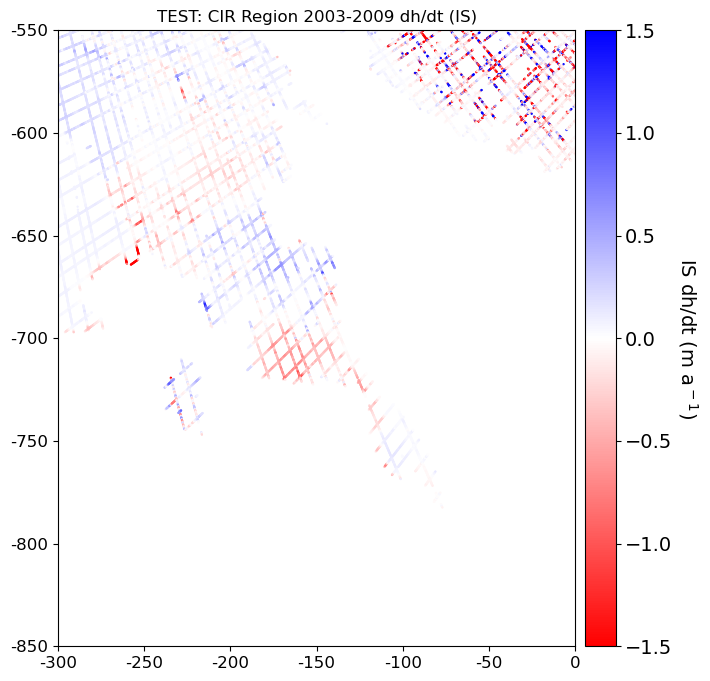

In [87]:
# Create the plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
# gdf.plot(facecolor="none", edgecolor="gray", zorder=2, lw=.7,ax=ax)
# gl.plot(facecolor="none", edgecolor="black", zorder=3,ax=ax)
im=ax.scatter(dhdt_out['x'], dhdt_out['y'], s=.4, c=(dhdt_out['dhdt']), vmin=-1.5, vmax=1.5, cmap='bwr_r', zorder=1)
ax.set(xlim=(-3e5, 0), ylim=(-8.5e5, -5.5e5))
ax.axes.yaxis.set_ticklabels(np.arange(-850,-500,50),fontsize=12)
ax.xaxis.set_ticklabels(np.arange(-300,50,50),fontsize=12)
cbar = fig.colorbar(im,ax=ax,pad=.015)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('IS dh/dt (m a$^-$$^1$)', rotation=270,fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.title('TEST: CIR Region 2003-2009 dh/dt (IS)')
plt.show()

once you have your ad-hoc reference track created around IS tracks, you can then use the ad hoc reference track locations (file with the x,y locations provided) to calcualte dhdt from CS2 and IS2:

In [39]:
# file path for the ad hoc reference track locations:
file_path = "/Users/hannah/Documents/Research/CraryIceRise/CryoSat2/xy_is_masked.csv"
# load into dataframe
df_is = pd.read_csv(file_path, header=0, names=['x_is', 'y_is'])

# Define the moving window that travels along ad hoc reference track
wind = 1   # along-track window of 1 km
skip = 0.25   # move 250 m along track for each estimate
min_at = 0
max_at = len(df_is['x_is'])

## CryoSat-2 dh/dt

In [123]:
# Directory containing all Swath/POCA CS2 files:
myDir = '/Users/hannah/Documents/Research/CraryIceRise/CryoSat2/cs2-crary-parquet/'

# Get list of files ending with '_new.parquet'
myFiles = sorted([file for file in os.listdir(myDir) if file.endswith('a.parquet')])

# Get list of smbcorr files ending with 'v1.2.1.parquet'
myFiles_smb = sorted([file for file in os.listdir(myDir) if file.endswith('v1.2.1.parquet')])

# define output file names
outfiles=['cs2matched_2010_2014_smb.csv','cs2matched_2011_2015_smb.csv','cs2matched_2012_2016_smb.csv','cs2matched_2013_2017_smb.csv','cs2matched_2014_2018_smb.csv','cs2matched_2015_2019_smb.csv','cs2matched_2016_2020_smb.csv','cs2matched_2017_2021_smb.csv','cs2matched_2018_2022_smb.csv'];
oi = 0
# Initialize empty list S. this is input to the dh/dt calculation
S = pd.DataFrame()

# Loop through all files in myFiles structure
for i in range(len(myFiles_smb)):
    print('starting file:', myFiles[i], 'and', myFiles_smb[i])

    if i+5<=12:
        for ii in range(i,i+5):
            print('working on:', myFiles[ii], 'and', myFiles_smb[ii])

            # Single out a file name
            file = os.path.join(myDir, myFiles[ii])
            file_smb = os.path.join(myDir, myFiles_smb[ii])
            
            # Read data from parquet files
            s = parquet.read_table(file).to_pandas() #x,y,elevation,uncert,isswath,inputfield,datetime
            smb = parquet.read_table(file_smb, columns=['zsurf']).to_pandas() #zsurf

            # Apply smb/fac correction
            s['elevation'] = s['elevation'] - smb['zsurf'].values

            # Bounding box
            crarymask = (s['x'] >= -3e5) & (s['x'] <= 0) & (s['y'] >= -8.5e5) & (s['y'] <= -5.5e5)

            # Append s to make a 5 yr record of elev
            S = pd.concat([S, s[crarymask]])

            # Clear variables
            del s
            del smb
        startdate = datetime(1970, 1, 1)
        dhdt_out = calcCrarydhdt(S,startdate,'CS2',S['datetime64'])
        print(np.nanmean(dhdt_out['dhdt']), 'stop now') 
        
        
        # Save the DataFrame to a CSV file - this is where dhdt calculations are stored.
        dhdt_out.to_csv(outfiles[oi], index=False)

        
        oi = oi+1
        del dhdt_out
    else:
        continue

starting file: cs2-crary-2010a.parquet and cs2-crary-2010_GSFC-fdm-v1.2.1.parquet
working on: cs2-crary-2010a.parquet and cs2-crary-2010_GSFC-fdm-v1.2.1.parquet
working on: cs2-crary-2011a.parquet and cs2-crary-2011_GSFC-fdm-v1.2.1.parquet
working on: cs2-crary-2012a.parquet and cs2-crary-2012_GSFC-fdm-v1.2.1.parquet
working on: cs2-crary-2013a.parquet and cs2-crary-2013_GSFC-fdm-v1.2.1.parquet
working on: cs2-crary-2014a.parquet and cs2-crary-2014_GSFC-fdm-v1.2.1.parquet
initializing dataframe
starting calc
working on point 1384 of 86530
-0.219271220572919 stop now
starting file: cs2-crary-2011a.parquet and cs2-crary-2011_GSFC-fdm-v1.2.1.parquet
working on: cs2-crary-2011a.parquet and cs2-crary-2011_GSFC-fdm-v1.2.1.parquet


KeyboardInterrupt: 

## ICESat-2 dh/dt

In [50]:
# Directory containing all IS2 files:
myDir = '/Users/hannah/Documents/Research/CraryIceRise/ICESat2/ATL06/'

# Get list of files ending with '_new.parquet'
myFiles = sorted([file for file in os.listdir(myDir) if file.endswith('_new.parquet')])

# Get list of smbcorr files ending with 'v1.2.1.parquet'
myFiles_smb = sorted([file for file in os.listdir(myDir) if file.endswith('v1.2.1.parquet')])

# Initialize empty list S. this is input to the dh/dt calculation
S = pd.DataFrame()

# Loop through all files in myFiles_smb structure
for i in range(len(myFiles_smb)):
    print('working on file:', myFiles[i], 'and', myFiles_smb[i])
    
    # Single out a file name
    file = os.path.join(myDir, myFiles[i])
    file_smb = os.path.join(myDir, myFiles_smb[i])
    
    # Read data from parquet files
    s = parquet.read_table(file).to_pandas()  # x,y,h_li,time
    smb = parquet.read_table(file_smb, columns=['zsurf']).to_pandas() #zsurf
    
    # Apply smb/fac correction
    if i == 16:  # Exclude 2023 from calculation
        mask2023 = ~smb['zsurf'].isnull()  # Mask out 2023
        s = s[mask2023]
        smb = smb[mask2023]
    
    s['h_li'] = s['h_li'] - smb['zsurf'].values
    
    # Bounding box
    crarymask = (s['x'] >= -3e5) & (s['x'] <= 0) & (s['y'] >= -8.5e5) & (s['y'] <= -5.5e5)
    
    # Append s to make a 5 yr record of elev
    # S.append(s[crarymask])
    S = pd.concat([S, s[crarymask]])
    
    # Clear variables
    del s
    del smb

working on file: 1_new.parquet and 1_new_GSFC-fdm-v1.2.1.parquet
working on file: 2_3_new.parquet and 2_3_new_GSFC-fdm-v1.2.1.parquet
working on file: 4_new.parquet and 4_new_GSFC-fdm-v1.2.1.parquet
working on file: 5_new.parquet and 5_new_GSFC-fdm-v1.2.1.parquet
working on file: 6_new.parquet and 6_new_GSFC-fdm-v1.2.1.parquet
working on file: 7_new.parquet and 7_new_GSFC-fdm-v1.2.1.parquet
working on file: 8_new.parquet and 8_new_GSFC-fdm-v1.2.1.parquet
working on file: 9_new.parquet and 9_new_GSFC-fdm-v1.2.1.parquet
working on file: _10_new.parquet and _10_new_GSFC-fdm-v1.2.1.parquet
working on file: _11_new.parquet and _11_new_GSFC-fdm-v1.2.1.parquet
working on file: _12_new.parquet and _12_new_GSFC-fdm-v1.2.1.parquet
working on file: _13_new.parquet and _13_new_GSFC-fdm-v1.2.1.parquet
working on file: _14_new.parquet and _14_new_GSFC-fdm-v1.2.1.parquet
working on file: _15_new.parquet and _15_new_GSFC-fdm-v1.2.1.parquet
working on file: _16_new.parquet and _16_new_GSFC-fdm-v1.2.1.p

In [81]:
# now call dh/dt function and ouput dhdt_out dataframe
startdate = datetime(2018, 1, 1)
dhdt_out = calcCrarydhdt(S,startdate,'IS2',S['time'])

# Save the DataFrame to a CSV file - this is where dhdt calculations are stored.
dhdt_out.to_csv('IS2_2018_2022_smbcorr_py.csv', index=False)

initializing dataframe
starting calc
working on point 1387 of 86530
working on is time conversion
